In [27]:
%matplotlib inline
from activ import load_data
from activ.data_normalization import data_normalization
from activ.analytics import nmf_bases_heatmap
from pyuoi.decomposition.NMF import UoINMF
from hdbscan import HDBSCAN
from sklearn.model_selection import KFold
from sklearn.decomposition import NMF
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict

In [28]:
data_dead = load_data(dead=True)

In [29]:
dead_bm = data_dead.biomarkers
dead_oc = data_dead.outcomes

In [30]:
ocnorm = data_normalization(data_dead.outcomes, 'positive')
bmnorm = data_normalization(data_dead.biomarkers, 'positive')

In [31]:
pls = PLSRegression(n_components=1)
pls.fit(bmnorm, ocnorm)

PLSRegression(copy=True, max_iter=500, n_components=1, scale=True, tol=1e-06)

In [32]:
bmnorm.shape

(276, 235)

In [33]:
pls.y_scores_.shape

(276, 1)

In [34]:
pls.x_scores_.shape

(276, 1)

In [35]:
_data = bmnorm
kf = KFold(n_splits=4)
n_boot = 40
min_pts = 20
ks = list(range(6,12))
y_true = pls.y_scores_.ravel()
# rec_err = np.zeros((kf.get_n_splits(), len(min_pts)))
num_bases = np.zeros(len(ks), dtype=int)
error_arr = np.zeros((len(ks)))
nmf = NMF(beta_loss='kullback-leibler', solver='mu', max_iter=5000, init='random')

for k_i, k in enumerate(ks):
#    uoinmf = UoINMF(n_bootstraps=n_boot, ranks=k, nmf=nmf, dbscan=HDBSCAN(min_cluster_size=20, core_dist_n_jobs=1))
    uoinmf = UoINMF(n_bootstraps=n_boot, ranks=k, nmf=nmf, dbscan=KMeans(n_clusters=k))
    uoinmf.fit(_data)
    tfm = uoinmf.transform(_data)
    rfr = RandomForestRegressor(n_estimators=100)
    pred = cross_val_predict(rfr, tfm, y_true, cv=5)
    num_bases[k_i] = tfm.shape[1]
    error_arr[k_i] = mean_squared_error(y_true, pred)
    print(k, num_bases[k_i], error_arr[k_i])

6 6 33.62404221594575
7 7 33.37536371249386
8 8 30.615486062120777
9 9 33.12949681650836
10 10 32.182699022558836
11 11 31.462758522312036


In [ ]:
plt.figure(figsize=(90, 30))
nmf_bases_heatmap(uoinmf.components_, col_labels=data_dead.outcome_features, sort=True, ax=None,
            cbar_kw={}, cbarlabel="", xlab='Outcome Features', ylab='Factors', aspect='auto',
            title='Outcome Factors')

In [20]:
bm_data = bmnorm
kf = KFold(n_splits=3)
n_boot = 20
min_pts = (5, 10, 15, 20, 25, 35, 45)
rec_err = np.zeros((kf.get_n_splits(), len(min_pts)))
num_bases = np.zeros((kf.get_n_splits(), len(min_pts)))
k = 0
for test, train in kf.split(bm_data):
    print(bm_data.shape)
    for i in range(len(min_pts)):
        uoinmf = UoINMF(ranks=list(range(2,10)),
                    dbscan=HDBSCAN(min_cluster_size=min_pts[i], core_dist_n_jobs=1))
        uoinmf.fit(bm_data[train])
        tfm = uoinmf.transform(bm_data[test])
        rec_err[k, i] = uoinmf.reconstruction_err_
        num_bases[k, i] = tfm.shape[1]
    k += 1

rec_error = np.mean(rec_err, axis=0)

(276, 235)
(276, 235)
(276, 235)


In [21]:
np.argmax(rec_err)

11

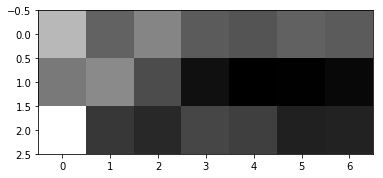

In [22]:
plt.imshow(rec_err, cmap='gray_r')

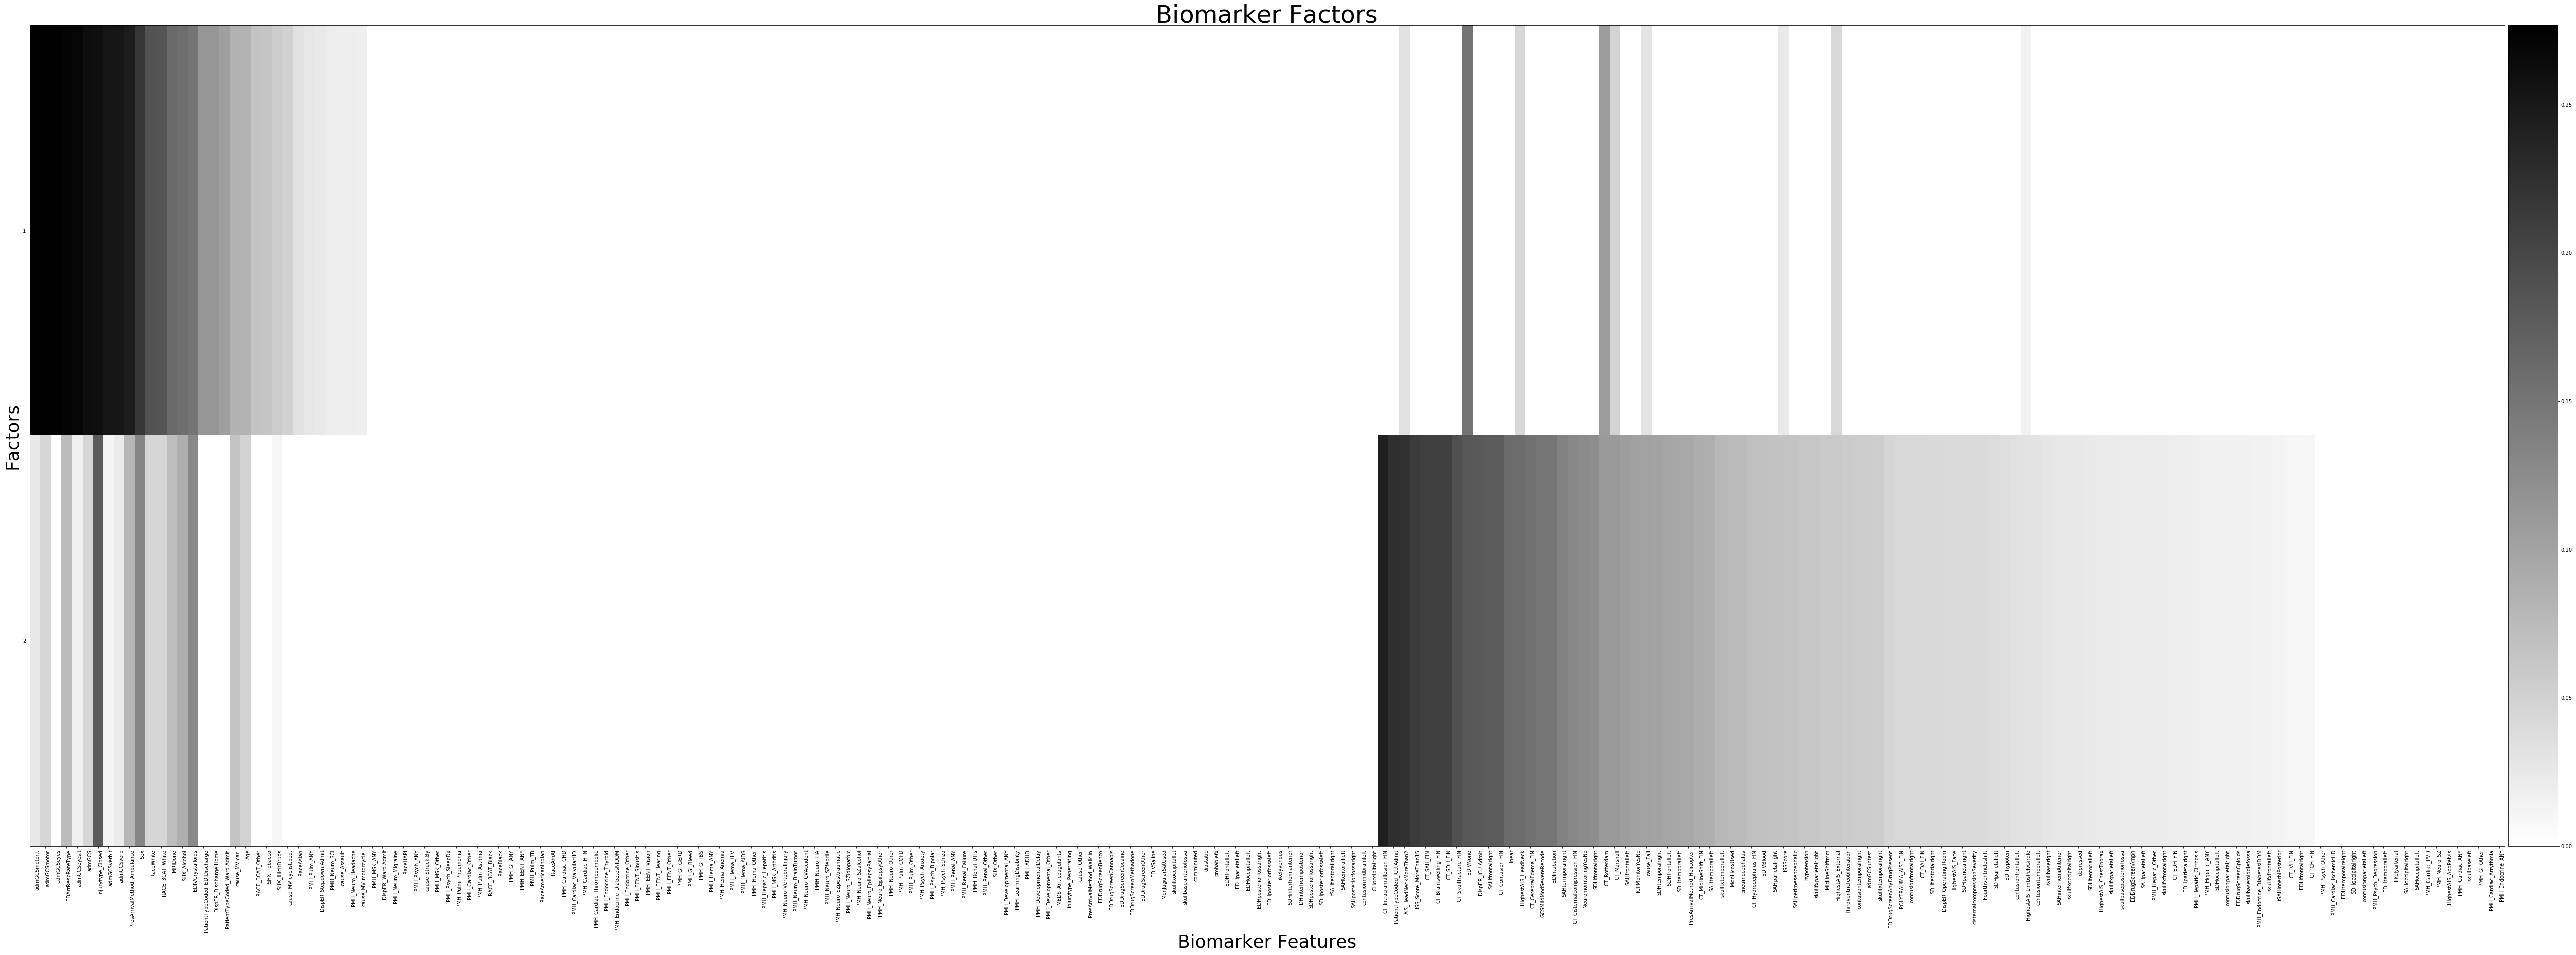

In [26]:
plt.figure(figsize=(90, 30))
nmf_bases_heatmap(uoinmf.components_, col_labels=data_dead.biomarker_features, sort=True, ax=None,
            cbar_kw={}, cbarlabel="", xlab='Biomarker Features', ylab='Factors', aspect='auto',
            title='Biomarker Factors')